# NSGA2 Generator
This notebook demonstrates the use of the generator `NSGA2Generator` which implements the NSGA-II algorithm from [1]. We show how to set up the optimizer object, use it to solve a test problem, and show off some of the generator's output features. Running this notebook will generate files in a temporary directory on your computer. These files will be cleaned up at the end.

In [1]:
import json
import logging
import matplotlib.pyplot as plt
import os
import pandas as pd
import shutil
import tempfile

from xopt.generators.ga.nsga2 import NSGA2Generator, PolynomialMutation, SimulatedBinaryCrossover
from xopt.resources.test_functions.zdt import construct_zdt
from xopt import Xopt, Evaluator

In [2]:
# The NSGA2Generator object emits logger messages
# Configure the logging module to output them to console
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',  # Format for log messages
    datefmt='%Y-%m-%d %H:%M:%S'  # Date/time format
)

In [3]:
# Get the problem ZDT2 and create an Xopt evaluator
prob_vocs, prob_fun, _ = construct_zdt(30, 3)
ev = Evaluator(function=prob_fun)

### Generator Setup and Use
First we create the `NSGA2Generator` object, demonstrate some of its settings, and then use it to solve the ZDT3 test problem.

In [4]:
# Create the NSGA2 generator with default settings
generator = NSGA2Generator(
    vocs=prob_vocs,  # Must provide the problem's details
)

# Let's demonstrate controlling the generator's hyperparameters and settings
generator = NSGA2Generator(
    vocs=prob_vocs,  # Must provide the problem's details
    population_size=50,  # How many individuals in a population
    mutation_operator=PolynomialMutation(pm=1/30, eta_m=20),  # Can manually specify mutation operator and hyperparameters
    crossover_operator=SimulatedBinaryCrossover(delta_1=0.5, delta_2=0.5, eta_c=20),  # Similarly can specify crossover manually
    deduplicate_output=True,  # Performs deduplication of candidate individuals. Ensure unique outputs from generator.
)

2025-03-02 18:49:21 - xopt.generator - INFO - Initialized generator nsga2
2025-03-02 18:49:21 - xopt.generator - INFO - Initialized generator nsga2


In [5]:
# Run the optimizer for a few generations. Notice log output printed below this cell
ev.max_workers = generator.population_size
X = Xopt(generator=generator, evaluator=ev, vocs=prob_vocs)

for _ in range(3):
    X.step()

2025-03-02 18:49:21 - xopt.base - INFO - Running Xopt step
2025-03-02 18:49:21 - xopt.generators.deduplicated - INFO - generated 50 candidates in 3.11ms (removed 0 duplicate individuals)
2025-03-02 18:49:21 - xopt.generators.ga.nsga2 - INFO - adding 50 new evaluated individuals to generator
2025-03-02 18:49:21 - xopt.generators.ga.nsga2 - INFO - completed generation 1 in 0.023s (n_feasible=0, n_err=0, children_performance=0.000s (0.000s), add_data_round=0, fevals=50, n_candidates=50)
2025-03-02 18:49:21 - xopt.base - INFO - Running Xopt step
2025-03-02 18:49:21 - xopt.generators.deduplicated - INFO - generated 50 candidates in 15.38ms (removed 0 duplicate individuals)
2025-03-02 18:49:21 - xopt.generators.ga.nsga2 - INFO - adding 50 new evaluated individuals to generator
2025-03-02 18:49:21 - xopt.generators.ga.nsga2 - INFO - completed generation 2 in 0.027s (n_feasible=0, n_err=0, children_performance=0.000s (0.000s), add_data_round=0, fevals=100, n_candidates=100)
2025-03-02 18:49:21

### Exploring Optimizer Output
We now take a look at the metadata associated with the optimizer run as well as its output.

In [6]:
%%time
# Run for longer with log output turned off
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

for _ in range(47):
    X.step()

CPU times: total: 797 ms
Wall time: 904 ms


In [7]:
# Inspect generator properties
print(f"Saw {generator.fevals} function evaluations")  # Number of function evaluations returned to generator
print(f"Completed {generator.n_generations} generations")  # Number of generations finished
print(f"Generated {generator.n_candidates} candidate solutions")  # Number of individuals generated

Saw 2500 function evaluations
Completed 50 generations
Generated 2500 candidate solutions


In [8]:
# All evaluations are stored in the following Dataframe. Speific to this generator, a `xopt_parent_generation` and 
# `xopt_candidate_idx` columns which indicate from which generation the indvidual's parents belong to as well as providing a 
# unique index for indviduals.
# 
# NOTE: The data DataFrame is not stored when serializing the generator. It must be saved on its own for later use.
generator.data.head()

,x1,x10,x11,x12,x13,x14,x15,x16,x17,x18,...,x7,x8,x9,xopt_parent_generation,xopt_candidate_idx,f1,f2,g,xopt_runtime,xopt_error
0,0.001910,0.161905,0.959764,0.771560,0.693129,0.199598,0.434305,0.045606,0.910929,0.456925,...,0.903176,0.879495,0.543015,0,6,0.001910,5.398837,5.501455,0.000046,False
1,0.093479,0.299127,0.899938,0.933696,0.496750,0.652871,0.088623,0.961892,0.253206,0.067463,...,0.374300,0.727794,0.872326,0,13,0.093479,5.053610,5.809561,0.000013,False
2,0.116253,0.209314,0.391717,0.170468,0.247075,0.367229,0.628942,0.270702,0.310282,0.136247,...,0.642663,0.612930,0.275460,0,30,0.116253,3.904499,4.577142,0.000010,False
3,0.137483,0.908016,0.540473,0.670818,0.106059,0.064833,0.467489,0.758627,0.008187,0.076547,...,0.982558,0.468550,0.913502,0,24,0.137483,5.247012,6.030572,0.000009,False
4,0.156759,0.803998,0.250071,0.983359,0.684111,0.015973,0.980164,0.414212,0.886125,0.349610,...,0.572851,0.235206,0.533540,0,36,0.156759,4.655016,5.423862,0.000009,False


In [9]:
# Each population the optimizer has seen is stored by the unique indices of each individual.
print(generator.history_idx[-1][:16])  # Show the first few indices of last generation

# If you have the data DataFrame you can extract all variables, objectives, constraints for each population
# Get a DataFrame of all information for the first population with every row being an individual
generator.data[generator.data["xopt_candidate_idx"].isin(generator.history_idx[0])].head()

[2489, 2261, 2499, 2266, 2485, 2459, 2372, 2472, 2447, 2484, 2428, 2450, 2466, 2480, 2464, 2414]


,x1,x10,x11,x12,x13,x14,x15,x16,x17,x18,...,x7,x8,x9,xopt_parent_generation,xopt_candidate_idx,f1,f2,g,xopt_runtime,xopt_error
0,0.001910,0.161905,0.959764,0.771560,0.693129,0.199598,0.434305,0.045606,0.910929,0.456925,...,0.903176,0.879495,0.543015,0,6,0.001910,5.398837,5.501455,0.000046,False
1,0.093479,0.299127,0.899938,0.933696,0.496750,0.652871,0.088623,0.961892,0.253206,0.067463,...,0.374300,0.727794,0.872326,0,13,0.093479,5.053610,5.809561,0.000013,False
2,0.116253,0.209314,0.391717,0.170468,0.247075,0.367229,0.628942,0.270702,0.310282,0.136247,...,0.642663,0.612930,0.275460,0,30,0.116253,3.904499,4.577142,0.000010,False
3,0.137483,0.908016,0.540473,0.670818,0.106059,0.064833,0.467489,0.758627,0.008187,0.076547,...,0.982558,0.468550,0.913502,0,24,0.137483,5.247012,6.030572,0.000009,False
4,0.156759,0.803998,0.250071,0.983359,0.684111,0.015973,0.980164,0.414212,0.886125,0.349610,...,0.572851,0.235206,0.533540,0,36,0.156759,4.655016,5.423862,0.000009,False


Text(0.5, 1.0, 'ZDT3, Generation 50')

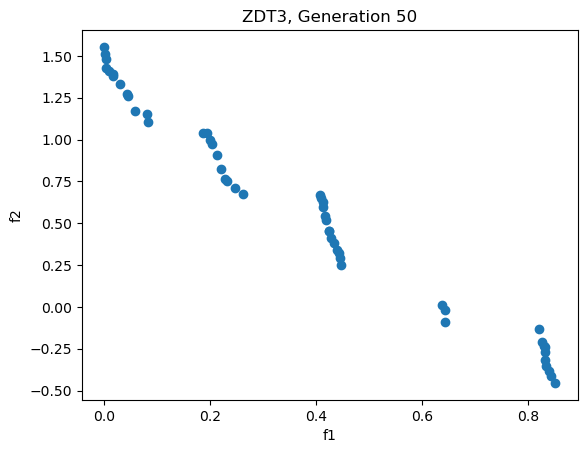

In [10]:
# Using the population records we can plot the final generation's objective functions
final_pop = generator.data[generator.data["xopt_candidate_idx"].isin(generator.history_idx[-1])]
plt.scatter(final_pop["f1"], final_pop["f2"])
plt.xlabel("f1")
plt.ylabel("f2")
plt.title(f"ZDT3, Generation {generator.n_generations}")

# File Output from Generator
In this section, we will take a look at the files which can be automatically written by the optimizer. We will create a temporary directory and clean it up at the end of this notebook.

The output files are the following.
 - `data.csv`: All data evaluated during the optimization
 - `populations.csv`: Each population is written here with a column `xopt_generation` to distinguish which generation the row belongs to
 - `checkpoints`: This generator periodically saves its full state to timestamped files in this directory

In [11]:
# Setup our output directory
output_dir = tempfile.mkdtemp()
print(f"Will write data to \"{output_dir}\"")

Will write data to "C:\Users\chris\AppData\Local\Temp\tmpnnjtv1ld"


In [12]:
# Set up a generator configured to output data
generator = NSGA2Generator(
    vocs=prob_vocs,
    output_dir=output_dir,  # Where will we write data
    checkpoint_freq=8,  # How often (in terms of generations) should we save the optimizer state?
)

# Run it for a couple of generations
ev.max_workers = generator.population_size
X = Xopt(generator=generator, evaluator=ev, vocs=prob_vocs)
for _ in range(32):
    X.step()

In [13]:
# Check out the generated files
print(f"\"{output_dir}\": {os.listdir(output_dir)}")
checkpoint_dir = os.path.join(output_dir, "checkpoints")
print(f"\"checkpoints\": {os.listdir(checkpoint_dir)}")

"C:\Users\chris\AppData\Local\Temp\tmpnnjtv1ld": ['checkpoints', 'data.csv', 'populations.csv']
"checkpoints": ['20250302_184922_1.txt', '20250302_184922_2.txt', '20250302_184923_1.txt', '20250302_184923_2.txt']


In [14]:
# In the event data was already written to `output_dir` the generator will choose a new path with a numeric suffix
# to avoid overwriting anything.
X = Xopt(generator=NSGA2Generator(vocs=prob_vocs, output_dir=output_dir), evaluator=ev, vocs=prob_vocs)
for _ in range(32):
    X.step()

# Compare the requested path and where the data ended up
print(f"Requested path: \"{output_dir}\"")
print(f"Path used:      \"{X.generator.output_dir}\"")

Requested path: "C:\Users\chris\AppData\Local\Temp\tmpnnjtv1ld"
Path used:      "C:\Users\chris\AppData\Local\Temp\tmpnnjtv1ld_2"


In [15]:
# Load all data back in
df = pd.read_csv(os.path.join(generator.output_dir, "data.csv"))
df.head()

,x1,x10,x11,x12,x13,x14,x15,x16,x17,x18,...,x7,x8,x9,xopt_parent_generation,xopt_candidate_idx,f1,f2,g,xopt_runtime,xopt_error
0,0.012037,0.570100,0.473145,0.465675,0.173298,0.936904,0.357542,0.377831,0.451588,0.409434,...,0.001926,0.838165,0.493611,0,15,0.012037,5.384632,5.649860,0.000047,False
1,0.036886,0.830700,0.110794,0.987415,0.002921,0.100157,0.417006,0.836205,0.846725,0.379568,...,0.541604,0.533394,0.754277,0,18,0.036886,5.291699,5.787540,0.000016,False
2,0.043234,0.489989,0.863005,0.054827,0.103942,0.474459,0.327162,0.485508,0.849475,0.784724,...,0.853875,0.170574,0.778310,0,36,0.043234,5.194790,5.734996,0.000014,False
3,0.075405,0.759897,0.574727,0.309663,0.544979,0.762226,0.450214,0.975906,0.985243,0.359688,...,0.216169,0.884312,0.552355,0,22,0.075405,5.301995,6.028878,0.000013,False
4,0.081115,0.173384,0.301405,0.394442,0.583225,0.237865,0.025349,0.247782,0.613693,0.928893,...,0.708416,0.647222,0.424569,0,42,0.081115,4.973961,5.699234,0.000013,False


In [16]:
# Load the populations and get just the last population
df = pd.read_csv(os.path.join(generator.output_dir, "populations.csv"))
last_pop = df[df["xopt_generation"] == df["xopt_generation"].max()]
last_pop.head()

,x1,x10,x11,x12,x13,x14,x15,x16,x17,x18,...,x8,x9,xopt_parent_generation,xopt_candidate_idx,f1,f2,g,xopt_runtime,xopt_error,xopt_generation
1550,0.857651,0.048621,0.020767,0.040603,0.151245,0.153961,0.159449,0.259999,0.091697,0.000284,...,0.161984,0.103764,30,1525,0.857651,-0.078114,2.095468,0.000008,False,32
1551,0.000234,0.046611,0.141661,0.041206,0.150799,0.106628,0.134775,0.139560,0.097422,0.004697,...,0.161590,0.006208,31,1593,0.000234,2.054160,2.076180,0.000029,False,32
1552,0.638815,0.048700,0.010461,0.048346,0.150230,0.019792,0.123474,0.141353,0.009154,0.003276,...,0.138478,0.032256,30,1519,0.638815,0.235626,1.952113,0.000008,False,32
1553,0.828017,0.048395,0.003509,0.035825,0.150202,0.048272,0.141441,0.260581,0.091697,0.000283,...,0.161984,0.103764,30,1529,0.828017,0.154043,2.115974,0.000008,False,32
1554,0.454003,0.036418,0.019510,0.047362,0.149692,0.054218,0.139828,0.260394,0.096817,0.004531,...,0.161882,0.005335,31,1594,0.454003,0.571735,1.967199,0.000008,False,32


In [17]:
# Reload the optimizer from its last checkpoint
# NOTE: the vocs object is not retained with the checkpoint and should be added as in the following code
last_checkpoint = os.path.join(checkpoint_dir, os.listdir(checkpoint_dir)[-1])
with open(last_checkpoint) as f:
    restored_generator = NSGA2Generator.from_dict({"vocs": prob_vocs, **json.load(f)})
print(f"From file: {restored_generator}")

# Demonstrate using the generator after loading (starting optimization from its last saved point)
X = Xopt(generator=restored_generator, evaluator=ev, vocs=prob_vocs)
for _ in range(32):
    X.step()
print(f"Further optimization: {restored_generator}")

From file: NSGA2Generator(pop_size=50, crossover=SimulatedBinaryCrossover, mutation=PolynomialMutation, deduplicated=True, completed_gens=32, fevals=1600)
Further optimization: NSGA2Generator(pop_size=50, crossover=SimulatedBinaryCrossover, mutation=PolynomialMutation, deduplicated=True, completed_gens=64, fevals=3200)


In [18]:
# Clean up the output directory
shutil.rmtree(output_dir)